# Loading tools

In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import convert_to_tensor
from pathlib import Path

2024-04-07 10:32:45.427296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 10:32:45.427395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 10:32:45.564004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
!pip install mlxtend

## Creating Basket :p

In [4]:
import shutil
shutil.rmtree('/kaggle/working/', ignore_errors=True)

In [5]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

def create_train_test_split_dirs(root_path, dataset_folder, split_size):
    try:
        os.makedirs(os.path.join(root_path, 'training'))
        os.makedirs(os.path.join(root_path, 'testing'))

        # Get the list of subdirectories (each subdirectory is a class)
        class_folders = os.listdir(os.path.join(root_path, dataset_folder))

        for class_folder in class_folders:
            os.makedirs(os.path.join(root_path, 'training', class_folder))
            os.makedirs(os.path.join(root_path, 'testing', class_folder))

            class_path = os.path.join(root_path, dataset_folder, class_folder)

            images = os.listdir(class_path)

            train_images, test_images = train_test_split(images, test_size=split_size, random_state=42)

            for img in train_images:
                source = os.path.join(class_path, img)
                destination = os.path.join(root_path, 'training', class_folder, img)
                copyfile(source, destination)

            for img in test_images:
                source = os.path.join(class_path, img)
                destination = os.path.join(root_path, 'testing', class_folder, img)
                copyfile(source, destination)

    except FileExistsError:
        print("Directories already exist.")

split_size = 0.2
root_dir = '/kaggle/working/'
dataset_folder = '/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification'
create_train_test_split_dirs(root_dir, dataset_folder, split_size)


In [6]:
source_dir = '/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification'
training_dir = '/kaggle/working/training'
testing_dir = '/kaggle/working/testing'

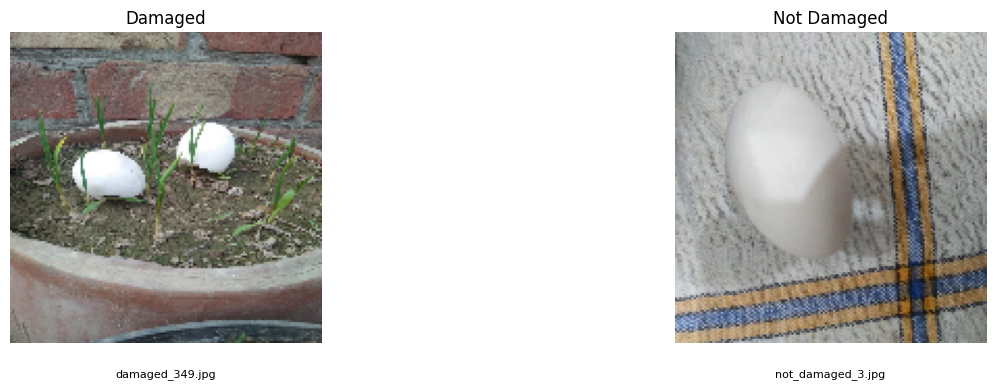

In [7]:
import os
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import random

training_dir = '/kaggle/working/training'

labels = sorted(os.listdir(training_dir))

def plot_categories(training_dir):
    fig, axes = plt.subplots(1, len(labels), figsize=(16, 4))

    for i, label in enumerate(labels):
        label_dir = os.path.join(training_dir, label)
        img_files = os.listdir(label_dir)

        random_img = random.choice(img_files)
        img_path = os.path.join(label_dir, random_img)
        img = load_img(img_path, target_size=(150, 150), color_mode="rgb")

        ax = axes[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.text(0.5, -0.1, random_img, fontsize=8, ha='center', va='center', transform=ax.transAxes)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


plot_categories(training_dir)


## Egg Properties

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

labels = sorted(os.listdir(training_dir))

for label in labels:
    class_folder = os.path.join(training_dir, label)
    image_files = os.listdir(class_folder)
    image_path = os.path.join(class_folder, image_files[0])

    image = cv2.imread(image_path)

    if image is not None:
        height, width, channels = image.shape
        print(f"Class: {label}")
        print(f"Image Dimensions: {width}x{height}")
        print(f"Number of Channels: {channels}")
        print()

    else:
        print(f"Error reading image for class {label}")


Class: Damaged
Image Dimensions: 1200x1600
Number of Channels: 3

Class: Not Damaged
Image Dimensions: 1200x1600
Number of Channels: 3



In [9]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(training_dir,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 634 images belonging to 2 classes.


In [11]:
train_generator

In [12]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 160 images belonging to 2 classes.


## Labelling Eggs

In [13]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Damaged
1 : Not Damaged


In [14]:
import tqdm

train_generator.reset()
X_train_list, y_train_list = [], []

for _ in tqdm.tqdm(range(int(train_generator.n / BATCH_SIZE) - 1)):
    img, label = next(train_generator)
    X_train_list.append(img)
    y_train_list.append(label)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print(X_train.shape, y_train.shape)


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

(512, 224, 224, 3) (512, 2)


In [15]:
import tqdm

validation_generator.reset()
X_test_list, y_test_list = [], []

for _ in tqdm.tqdm(range(int(validation_generator.n / BATCH_SIZE) - 1)):
    img, label = next(validation_generator)
    X_test_list.append(img)
    y_test_list.append(label)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(X_test.shape, y_test.shape)

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

(64, 224, 224, 3) (64, 2)


In [16]:
X_train.shape

(512, 224, 224, 3)

In [17]:
def create_model():
    model = Sequential([
        Conv2D(filters=16, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(5, 5), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=256, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),

        Dense(units=512, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0

In [18]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [19]:
layer = model.layers

## Visualizing the CNN

In [20]:
for i, layer in enumerate(model.layers):
    print(f"Layer Index: {i}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

Layer Index: 0, Layer Name: conv2d, Layer Type: Conv2D
Layer Index: 1, Layer Name: activation, Layer Type: Activation
Layer Index: 2, Layer Name: max_pooling2d, Layer Type: MaxPooling2D
Layer Index: 3, Layer Name: batch_normalization, Layer Type: BatchNormalization
Layer Index: 4, Layer Name: conv2d_1, Layer Type: Conv2D
Layer Index: 5, Layer Name: activation_1, Layer Type: Activation
Layer Index: 6, Layer Name: max_pooling2d_1, Layer Type: MaxPooling2D
Layer Index: 7, Layer Name: batch_normalization_1, Layer Type: BatchNormalization
Layer Index: 8, Layer Name: conv2d_2, Layer Type: Conv2D
Layer Index: 9, Layer Name: activation_2, Layer Type: Activation
Layer Index: 10, Layer Name: max_pooling2d_2, Layer Type: MaxPooling2D
Layer Index: 11, Layer Name: batch_normalization_2, Layer Type: BatchNormalization
Layer Index: 12, Layer Name: conv2d_3, Layer Type: Conv2D
Layer Index: 13, Layer Name: activation_3, Layer Type: Activation
Layer Index: 14, Layer Name: max_pooling2d_3, Layer Type: Ma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 19.3 MB/s eta 0:00:0000:01


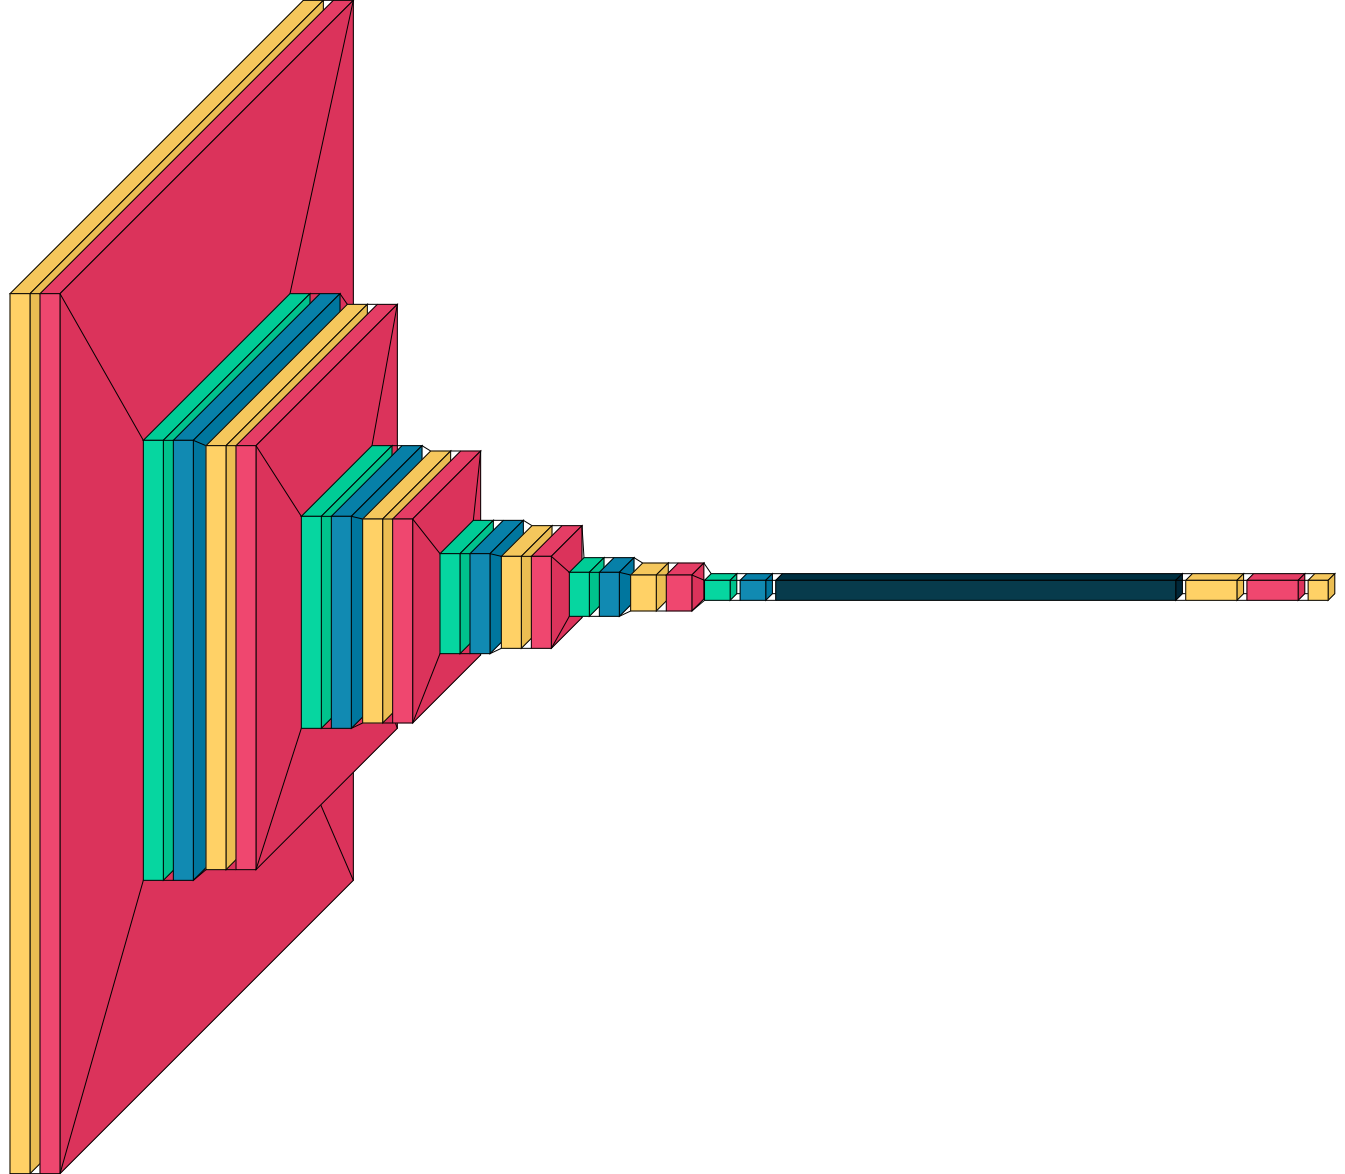

In [24]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model)

In [25]:
filters, biases = model.layers[0].get_weights()

In [26]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

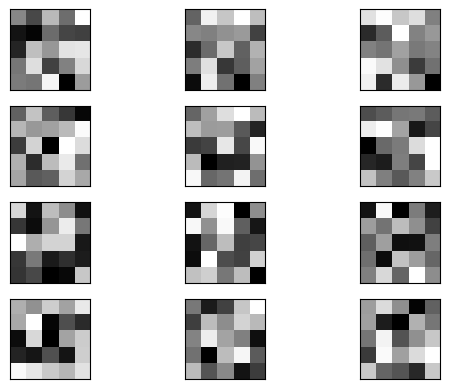

In [27]:
n_filters, ix = 4, 1
for i in range(n_filters):

  f = filters[:, :, :, i]

  for j in range(3):

    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1

plt.show()

In [28]:
for i in range(len(model.layers)):
 layer = model.layers[i]
 if 'conv' not in layer.name:
    continue

 print(i, layer.name, layer.output.shape)

0 conv2d (None, 220, 220, 16)
4 conv2d_1 (None, 106, 106, 32)
8 conv2d_2 (None, 51, 51, 64)
12 conv2d_3 (None, 23, 23, 128)
16 conv2d_4 (None, 9, 9, 256)


In [29]:
ixs = [0,4,8,12,16]
outputs = [model.layers[i].output for i in ixs]
model1 = Model(inputs=model.inputs, outputs=outputs)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832 

In [30]:
img = load_img('/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification/Not Damaged/not_damaged_1.jpg', target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model1.predict(img)

1/1 [==============================] - 2s 2s/step


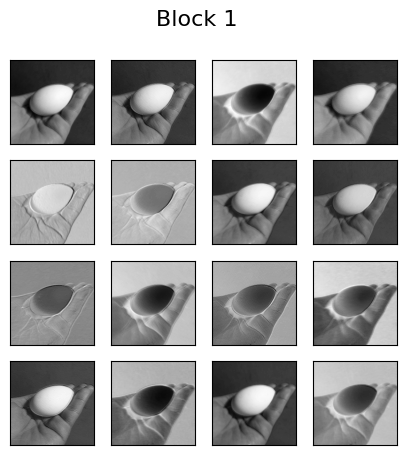

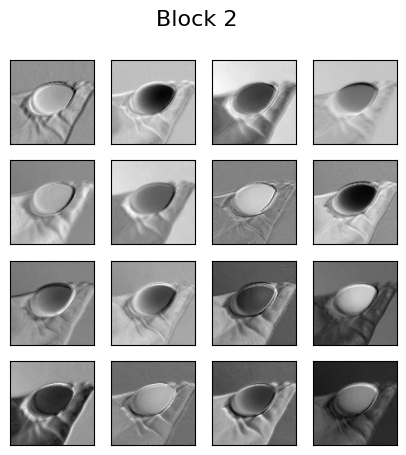

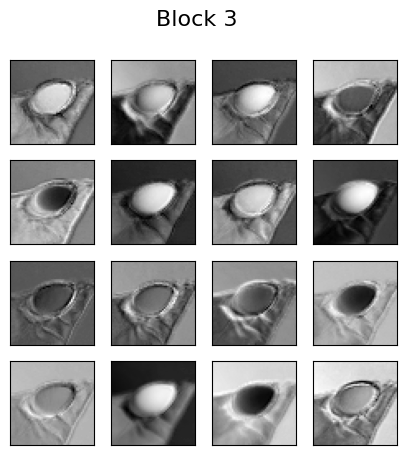

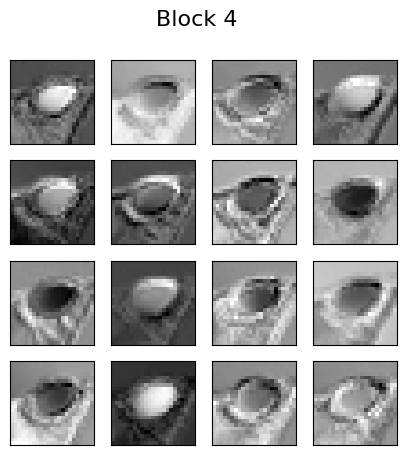

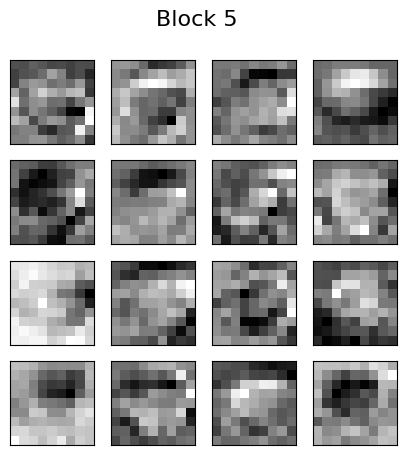

In [31]:
num_filters = 16

square = int(np.ceil(np.sqrt(num_filters))) 

for block_num, fmap in enumerate(feature_maps):

    fig = plt.figure(figsize=(5,5))
    plt.suptitle(f'Block {block_num + 1}', fontsize=16)

    ix = 1

    for _ in range(square):
        for _ in range(square):

            if ix <= num_filters:
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1

    plt.show()


In [32]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

Epoch 1/100


I0000 00:00:1712486250.526021     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 25s 2s/step - loss: 0.8252 - accuracy: 0.6877 - val_loss: 0.6767 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 18s 2s/step - loss: 0.6974 - accuracy: 0.7634 - val_loss: 0.6286 - val_accuracy: 0.7937
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.5161 - accuracy: 0.8060 - val_loss: 0.5982 - val_accuracy: 0.7937
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 0.4818 - accuracy: 0.8265 - val_loss: 0.5592 - val_accuracy: 0.7937
Epoch 5/100
10/10 [==============================] - 19s 2s/step - loss: 0.4456 - accuracy: 0.8233 - val_loss: 0.5738 - val_accuracy: 0.7937
Epoch 6/100
10/10 [==============================] - 18s 2s/step - loss: 0.3582 - accuracy: 0.8785 - val_loss: 0.5234 - val_accuracy: 0.7937
Epoch 7/100
10/10 [==============================] - 18s 2s/step - loss: 0.3703 - accuracy: 0.8533 - val_loss: 0.5349 - val_accuracy: 0.7937
Epoch 8/100
10/10 [======

In [35]:
mean_squared_error(model.predict(X_test), y_test)

2/2 [==============================] - 0s 12ms/step


0.05702318

In [36]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


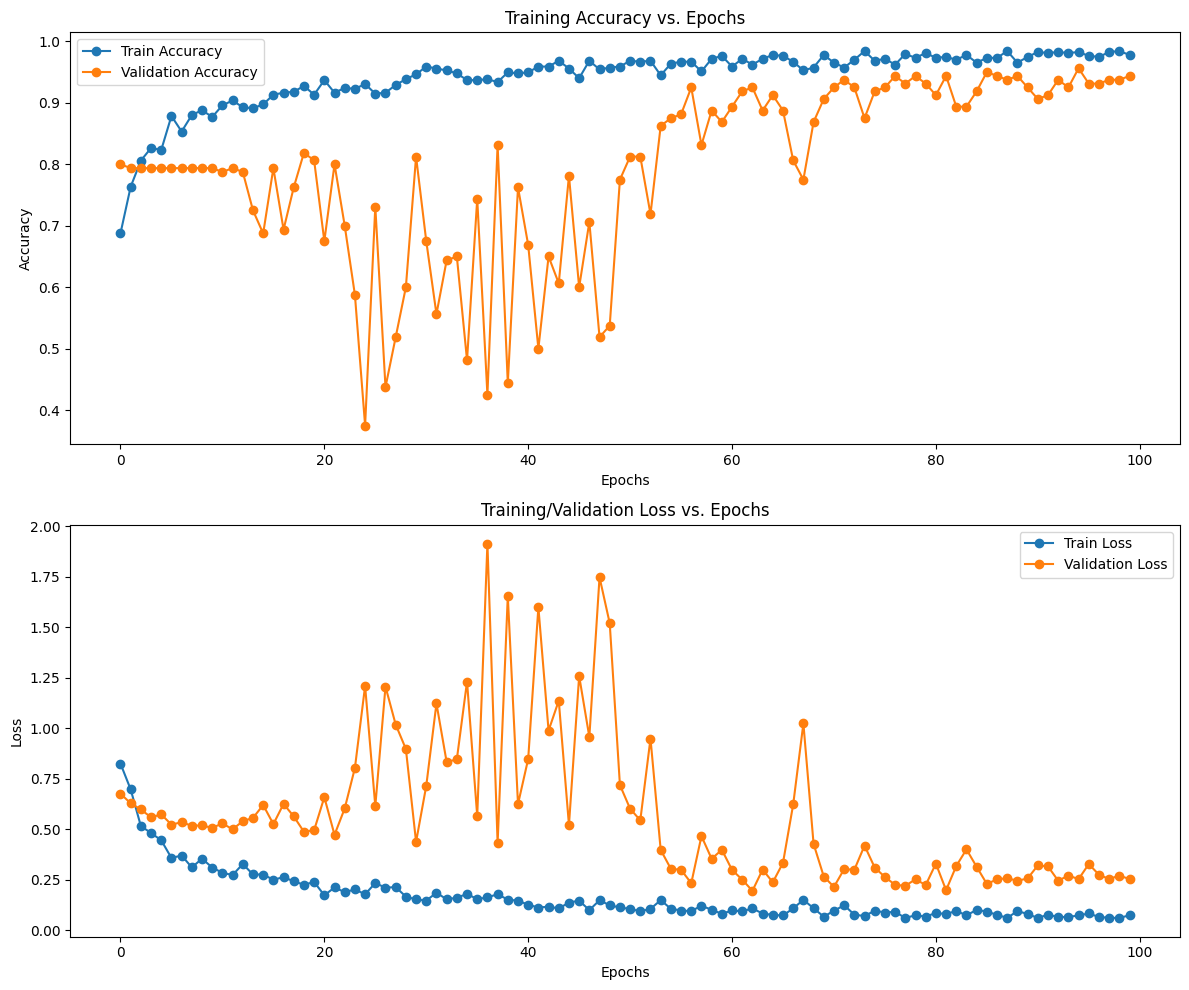

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [38]:
np.random.seed(1)
tf.random.set_seed(1)


y_pred = model.predict(X_test)

avg_bias = np.mean((y_test - np.mean(y_pred, axis=0))**2)
avg_var = np.mean(np.var(y_pred, axis=0))
avg_expected_loss = np.mean(mean_squared_error(y_test, y_pred))

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

2/2 [==============================] - 0s 13ms/step
Average expected loss: 0.057
Average bias: 0.162
Average variance: 0.146


In [39]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.applications import ResNet50  # Import ResNet50

IMG_WIDTH, IMG_HEIGHT = 224, 224  # Common input size for ResNet50

def create_resnet_model():
    input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Load pre-trained ResNet50 model, excluding top layers
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the pre-trained layers for transfer learning
    for layer in resnet.layers:
        layer.trainable = False

    # Flatten output from ResNet50
    flattened = Flatten()(resnet.output)

    # Add custom classification layers
    dense1 = Dense(512, activation='relu')(flattened)
    dropout = Dropout(0.5)(dense1)  # Regularization
    output_layer = Dense(2, activation='softmax')(dropout)  # Adjust for number of classes

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = create_resnet_model()
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (replace placeholders with your generators)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)


94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [40]:
mean_squared_error(model.predict(X_test), y_test)

2/2 [==============================] - 1s 57ms/step


0.14484334

In [41]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

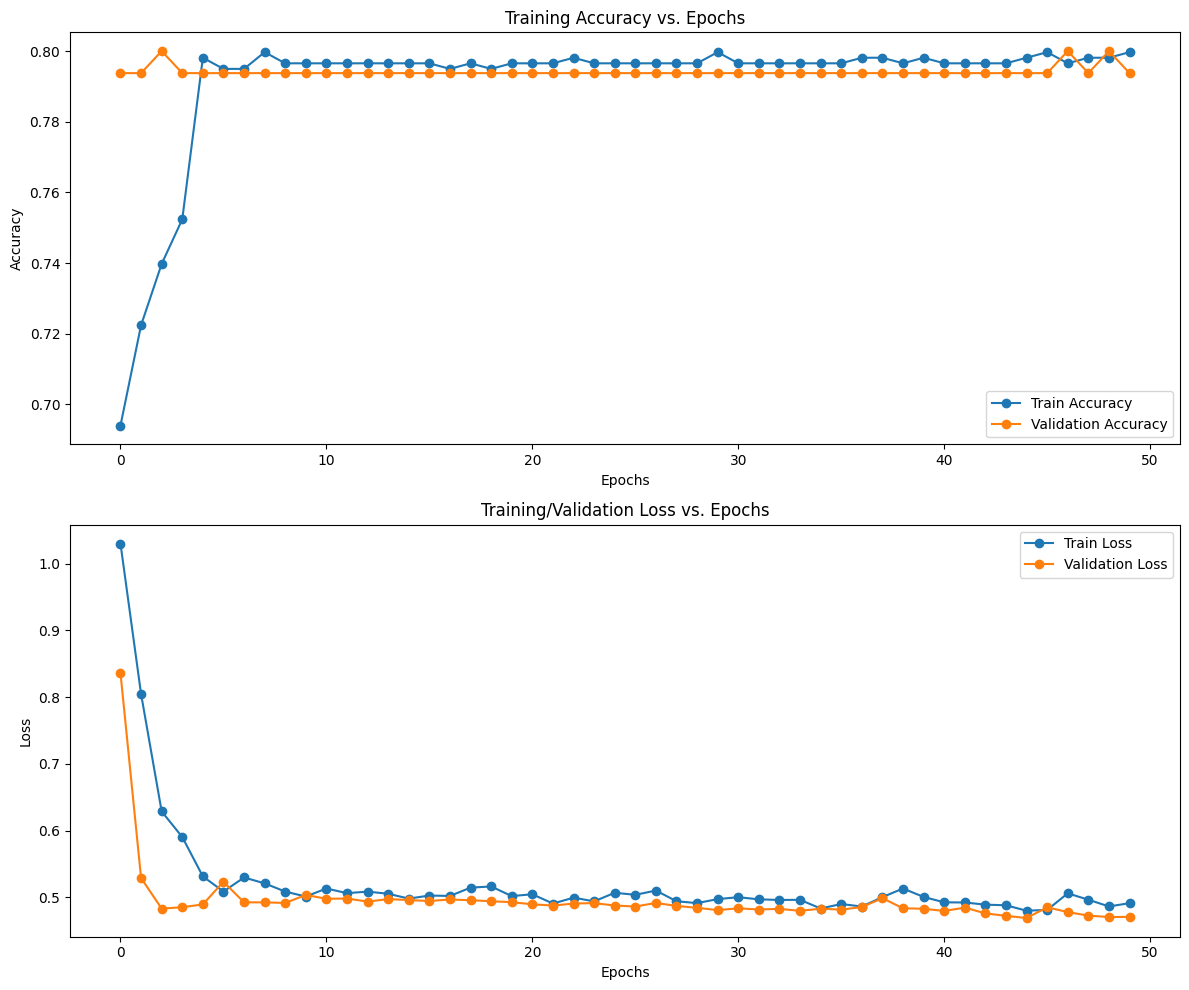

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [43]:
np.random.seed(1)
tf.random.set_seed(1)


y_pred = model.predict(X_test)

avg_bias = np.mean((y_test - np.mean(y_pred, axis=0))**2)
avg_var = np.mean(np.var(y_pred, axis=0))
avg_expected_loss = np.mean(mean_squared_error(y_test, y_pred))

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

2/2 [==============================] - 1s 56ms/step
Average expected loss: 0.145
Average bias: 0.162
Average variance: 0.004


In [44]:
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Common input size for AlexNet

def create_alexnet_model():
  model = Sequential()

  # First convolutional layer group
  model.add(Conv2D(filters=64, kernel_size=(11, 11), strides=(4, 4), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), kernel_regularizer=l2(0.0005)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Second convolutional layer group
  model.add(Conv2D(filters=192, kernel_size=(5, 5), padding='same', kernel_regularizer=l2(0.0005)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Third convolutional layer group
  model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  # Fourth convolutional layer group
  model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  # Fifth convolutional layer group
  model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  return model

model = create_alexnet_model()
model.summary()

# Compile the model (same as your previous code)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
  train_generator,
  epochs=50,
  validation_data=validation_generator
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 64)        23296     
                                                                 
 activation_5 (Activation)   (None, 54, 54, 64)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 54, 54, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 192)       307392    
                                                                 
 activation_6 (Activation)   (None, 26, 26, 192)      

In [45]:
mean_squared_error(model.predict(X_test), y_test)

2/2 [==============================] - 0s 12ms/step


0.64792055

In [46]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

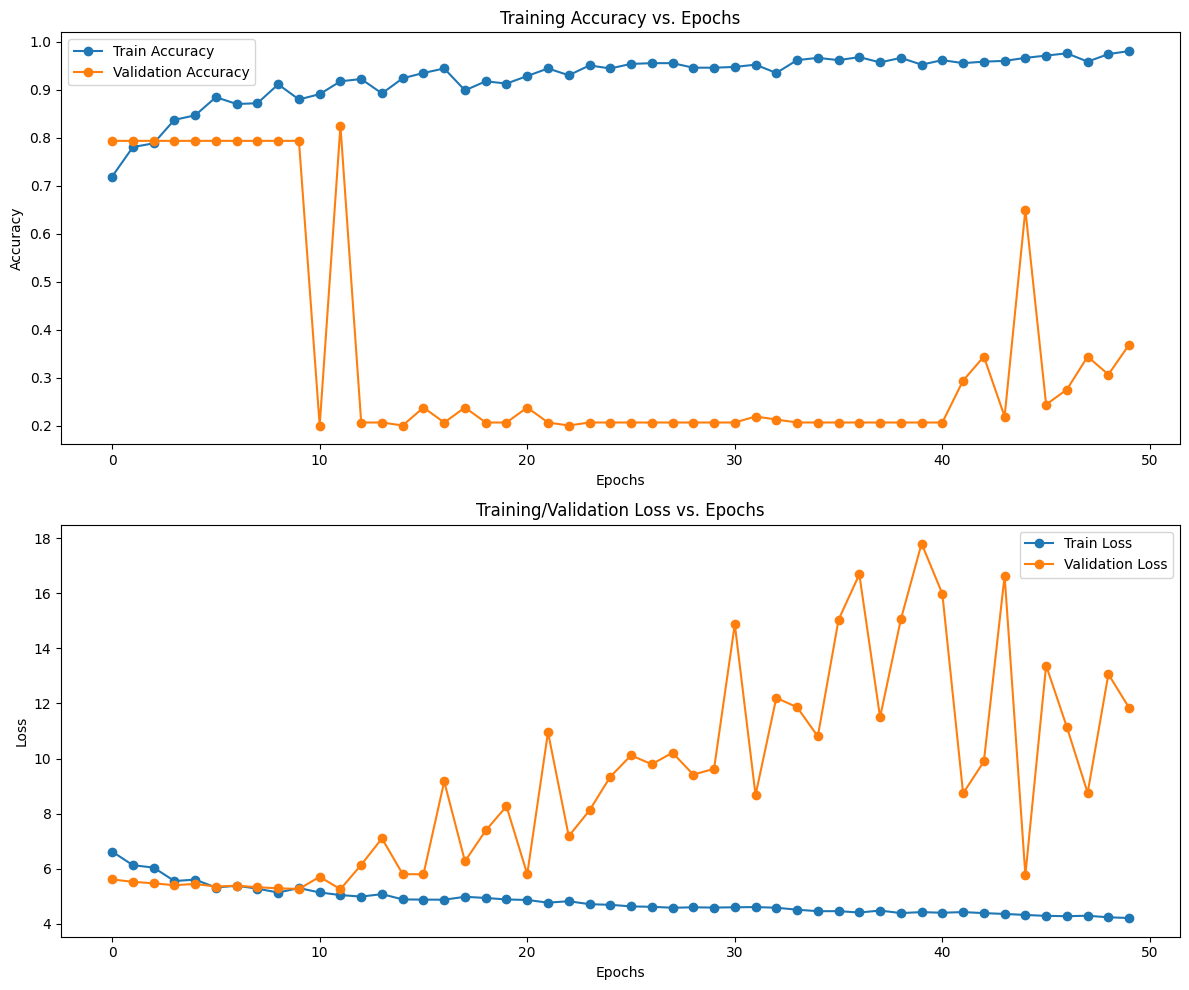

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [48]:
np.random.seed(1)
tf.random.set_seed(1)


y_pred = model.predict(X_test)

avg_bias = np.mean((y_test - np.mean(y_pred, axis=0))**2)
avg_var = np.mean(np.var(y_pred, axis=0))
avg_expected_loss = np.mean(mean_squared_error(y_test, y_pred))

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

2/2 [==============================] - 0s 11ms/step
Average expected loss: 0.648
Average bias: 0.597
Average variance: 0.104
